In [1]:

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import re
import pickle

## Loading data

In [2]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

In [3]:
train_data, valid_data = train_test_split(train_data, test_size=0.2, random_state=45, stratify=train_data.target)

## Analyzing data

In [4]:
train_data.head(3)

,id,keyword,location,text,target
6524,9332,survive,NaN,@DDNewsLive @NitishKumar and @ArvindKejriwal ...,0
3684,5243,fatality,NaN,[Jax(MK2)] Stage Fatality:UUD+LK (Close),0
6654,9537,terrorist,Florida,@lovemywife1983 @FoxNews like shedid on 9/11 4...,1


In [5]:
train_data["keyword"].value_counts().head(3)

keyword
fatalities    39
twister       37
sinking       35
Name: count, dtype: int64

In [6]:
train_data["location"].value_counts().head(3)

location
USA              83
New York         55
United States    45
Name: count, dtype: int64

In [7]:
# Regular expression pattern to match URLs
pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
def substitute_links(text):
    
    # Substitute links in the text with "website: domain_name"
    substituted_text = re.sub(pattern, 'website: domain_name', text)

    return substituted_text

# Example usage
text = "Check out this website: https://example.com and also visit http://openai.com"

substituted_text = substitute_links(text)
print(substituted_text)

Check out this website: website: domain_name and also visit website: domain_name


In [8]:
def clean_data(data:pd.DataFrame):
    data.drop(columns=["location", "id"], inplace=True)
    data.fillna("",inplace=True)
    data['text'] = data['text'].apply(substitute_links)

clean_data(train_data)
clean_data(test_data)
clean_data(valid_data)

In [9]:
train_labels = train_data.pop("target")
valid_labels = valid_data.pop("target")

In [10]:
train_data.head(3)

,keyword,text
6524,survive,@DDNewsLive @NitishKumar and @ArvindKejriwal ...
3684,fatality,[Jax(MK2)] Stage Fatality:UUD+LK (Close)
6654,terrorist,@lovemywife1983 @FoxNews like shedid on 9/11 4...


In [11]:
train_data.head(3)

,keyword,text
6524,survive,@DDNewsLive @NitishKumar and @ArvindKejriwal ...
3684,fatality,[Jax(MK2)] Stage Fatality:UUD+LK (Close)
6654,terrorist,@lovemywife1983 @FoxNews like shedid on 9/11 4...


In [12]:
print(f'No disaster: {train_data[train_labels == 0]["text"].values[1]}')
print(f'Disaster: {train_data[train_labels == 1]["text"].values[1]}')

No disaster: [Jax(MK2)] Stage Fatality:UUD+LK (Close)
Disaster: Investigators have said a Virgin Galactic spaceship crash was caused by structural failure after the co-pilot ... website: domain_name


In [13]:
print("Train shape:",train_data.shape)
print("Test shape:",test_data.shape)

Train shape: (6090, 2)
Test shape: (3263, 2)


In [14]:
train_labels.value_counts()

target
0    3473
1    2617
Name: count, dtype: int64

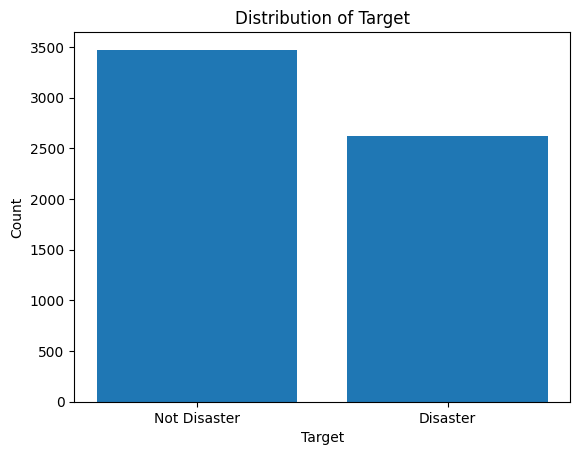

In [15]:
target_counts = train_labels.value_counts()

# Create a bar plot
plt.bar(target_counts.index, target_counts.values)
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks(target_counts.index, ['Not Disaster', 'Disaster'])
plt.title('Distribution of Target')
plt.show()

In [16]:
max_sequence_length = 0
max_sequence_length_keyword = 0
# Iterate over text and keyword columns
for text, keyword in zip(train_data['text'], train_data['keyword']):
    text_length = len(text.split())
    keyword_length = len(keyword.split())

    # Update maximum sequence length
    max_sequence_length = max(max_sequence_length, text_length, keyword_length)
    
for keyword in train_data['keyword']:
    keyword_length = len(keyword.split())

    # Update maximum sequence length
    max_sequence_length_keyword = max(max_sequence_length_keyword, keyword_length)

print("Maximum Sequence Length:", max_sequence_length)
print("Maximum Sequence Length Keyword:", max_sequence_length_keyword)

Maximum Sequence Length: 31
Maximum Sequence Length Keyword: 1


In [17]:

# Step 1: Tokenize text and keyword columns
text_tokenizer = Tokenizer()
text_tokenizer.fit_on_texts(train_data['text'])
train_text_sequences = text_tokenizer.texts_to_sequences(train_data['text'])

keyword_tokenizer = Tokenizer()
keyword_tokenizer.fit_on_texts(train_data['keyword'])
train_keyword_sequences = keyword_tokenizer.texts_to_sequences(train_data['keyword'])

def process_data(data:pd.DataFrame):
    #Tokenize
    text_sequences = text_tokenizer.texts_to_sequences(data["text"])
    keyword_sequences = keyword_tokenizer.texts_to_sequences(data["text"])
    
    #Pad
    text_sequences = pad_sequences(text_sequences, maxlen=max_sequence_length)
    keyword_sequences = pad_sequences(keyword_sequences, maxlen=max_sequence_length_keyword)
    return text_sequences, keyword_sequences

# Step 2: Pad sequences
# Adjust this value based on your data
train_text_sequences, train_keyword_sequences = process_data(train_data)

# Step 3: Create the dataset
labels = train_labels
dataset = tf.data.Dataset.from_tensor_slices(((train_text_sequences, train_keyword_sequences), labels))
dataset = dataset.shuffle(1000).batch(32)


In [30]:
# Save the text_tokenizer to a file
with open('text_tokenizer.pkl', 'wb') as file:
    pickle.dump(text_tokenizer, file)
file.close()

# Save the keyword_tokenizer to a file
with open('keyword_tokenizer.pkl', 'wb') as file:
    pickle.dump(keyword_tokenizer, file)
file.close()

NameError: name 'pickle' is not defined

In [18]:
w_index = 1
print(train_data["text"][0].split()[w_index])
print(text_tokenizer.texts_to_sequences(train_data["text"][0].split()[w_index]))

Deeds
[[443], [554], [554], [443], [100]]


In [19]:
print(train_data["text"][0])
print(train_data["text"][0].split())
print(len(train_data["text"][0].split()))
print(len(text_tokenizer.texts_to_sequences(train_data["text"][0])))
text_tokenizer.texts_to_sequences(train_data["text"][0])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
['Our', 'Deeds', 'are', 'the', 'Reason', 'of', 'this', '#earthquake', 'May', 'ALLAH', 'Forgive', 'us', 'all']
13
69


[[297],
 [82],
 [546],
 [],
 [443],
 [554],
 [554],
 [443],
 [100],
 [],
 [5],
 [546],
 [554],
 [],
 [701],
 [1444],
 [554],
 [],
 [546],
 [554],
 [5],
 [100],
 [297],
 [499],
 [],
 [297],
 [1028],
 [],
 [701],
 [1444],
 [10],
 [100],
 [],
 [],
 [554],
 [5],
 [546],
 [701],
 [1444],
 [3398],
 [82],
 [5],
 [2236],
 [554],
 [],
 [272],
 [5],
 [3271],
 [],
 [5],
 [1726],
 [1726],
 [5],
 [1444],
 [],
 [1028],
 [297],
 [546],
 [1530],
 [10],
 [1217],
 [554],
 [],
 [82],
 [100],
 [],
 [5],
 [1726],
 [1726]]

In [20]:
# Define the inputs
input_text = Input(shape=(max_sequence_length,), name='input_text')
input_keyword = Input(shape=(max_sequence_length_keyword,), name='input_keyword')

# Text part
embedding = Embedding(name="embedding",input_dim=len(text_tokenizer.word_index) + 1, output_dim=16, input_length=max_sequence_length)(input_text)
lstm_text = Bidirectional(LSTM(16, return_sequences=True))(embedding)

# Keyword part
keyword_embedding = Embedding(name="embedding_keyword",input_dim=len(keyword_tokenizer.word_index) + 1, output_dim=16, input_length=max_sequence_length_keyword)(input_keyword)
dense_keyword = Dense(8, activation='tanh')(keyword_embedding)
# dense_keyword2 = Dense(8, activation='relu')(dropout_k)
# dropout_k2 = Dropout(0.15)(dense_keyword)
dense_keyword_reshaped = Reshape((-1,))(dense_keyword)
dense_keyword_repeated = RepeatVector(max_sequence_length)(dense_keyword_reshaped)

# Concatenate the outputs
concatenated = Concatenate(axis=-1)([lstm_text, dense_keyword_repeated])

# Other layers
flatten = Flatten()(concatenated)
dense = Dense(4, activation='relu')(flatten)
dropout = Dropout(0.25)(dense)
dense3 = Dense(2, activation='tanh')(dropout)
output = Dense(2, activation='softmax')(dense3)

# Create the model
model = tf.keras.Model(inputs=[input_text, input_keyword], outputs=output)

In [21]:
# when using multiple output
labels = to_categorical(labels, num_classes=2)
valid_labels = to_categorical(valid_labels, num_classes=2)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_keyword (InputLayer)  [(None, 1)]                  0         []                            
                                                                                                  
 embedding_keyword (Embeddi  (None, 1, 16)                3840      ['input_keyword[0][0]']       
 ng)                                                                                              
                                                                                                  
 input_text (InputLayer)     [(None, 31)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 1, 8)                 136       ['embedding_keyword[0][0]'

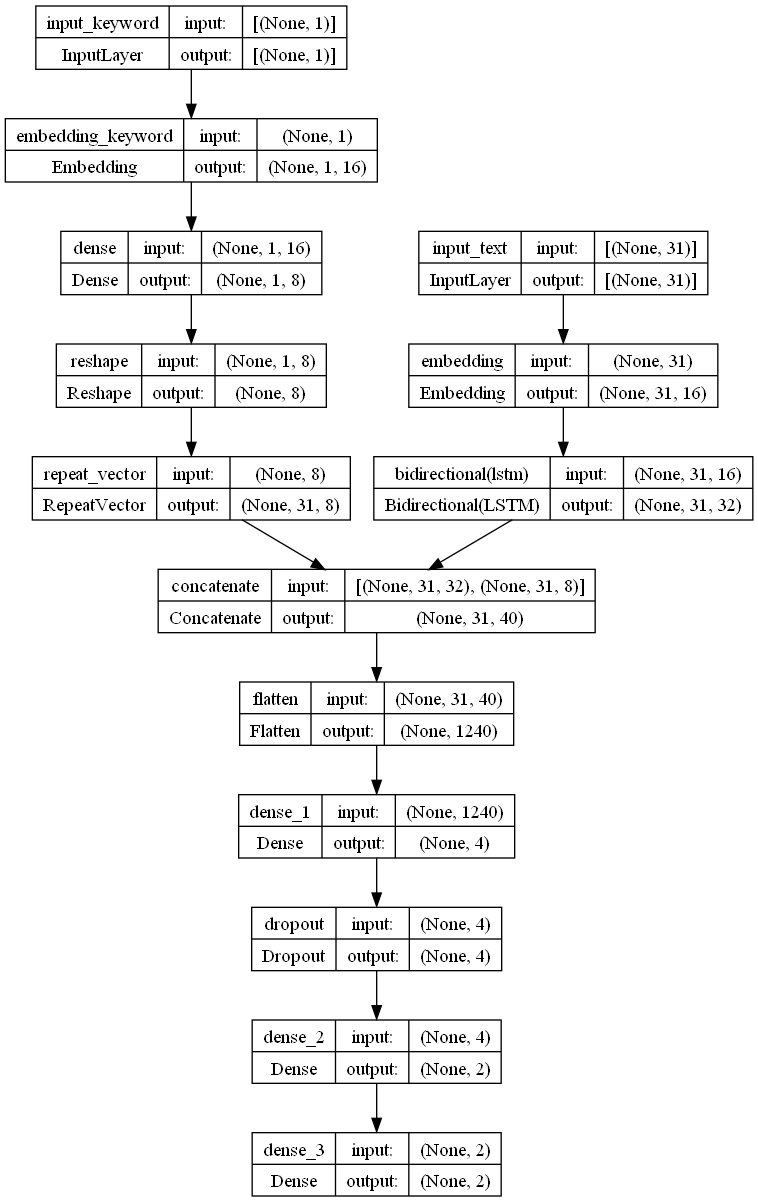

In [23]:
plot_model(model, show_shapes=True)

In [24]:
valid_text, valid_keyword = process_data(valid_data)

In [25]:
# Compile the model 
opt = tf.keras.optimizers.Adam(0.0001) #75
# opt = tf.keras.optimizers.Adagrad(learning_rate=0.0001)


model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy',keras.metrics.AUC()])


# Train the model
h = model.fit(
    {'input_text': train_text_sequences, 'input_keyword': train_keyword_sequences}, 
    labels, 
    validation_data=(
        {'input_text': valid_text, 'input_keyword': valid_keyword},
        valid_labels
        ),
    epochs=5)

Epoch 1/5
191/191 [==============================] - 7s 15ms/step - loss: 0.6890 - accuracy: 0.5658 - auc: 0.5804 - val_loss: 0.6813 - val_accuracy: 0.5706 - val_auc: 0.6594
Epoch 2/5
191/191 [==============================] - 2s 11ms/step - loss: 0.6703 - accuracy: 0.6038 - auc: 0.6643 - val_loss: 0.6484 - val_accuracy: 0.6651 - val_auc: 0.7269
Epoch 3/5
191/191 [==============================] - 2s 10ms/step - loss: 0.6316 - accuracy: 0.6962 - auc: 0.7678 - val_loss: 0.6045 - val_accuracy: 0.7341 - val_auc: 0.7764
Epoch 4/5
191/191 [==============================] - 2s 10ms/step - loss: 0.5843 - accuracy: 0.7343 - auc: 0.8201 - val_loss: 0.5623 - val_accuracy: 0.7663 - val_auc: 0.8090
Epoch 5/5
191/191 [==============================] - 2s 10ms/step - loss: 0.5322 - accuracy: 0.7800 - auc: 0.8631 - val_loss: 0.5433 - val_accuracy: 0.7827 - val_auc: 0.8114


In [26]:
history = h.history
print(history.keys())

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])


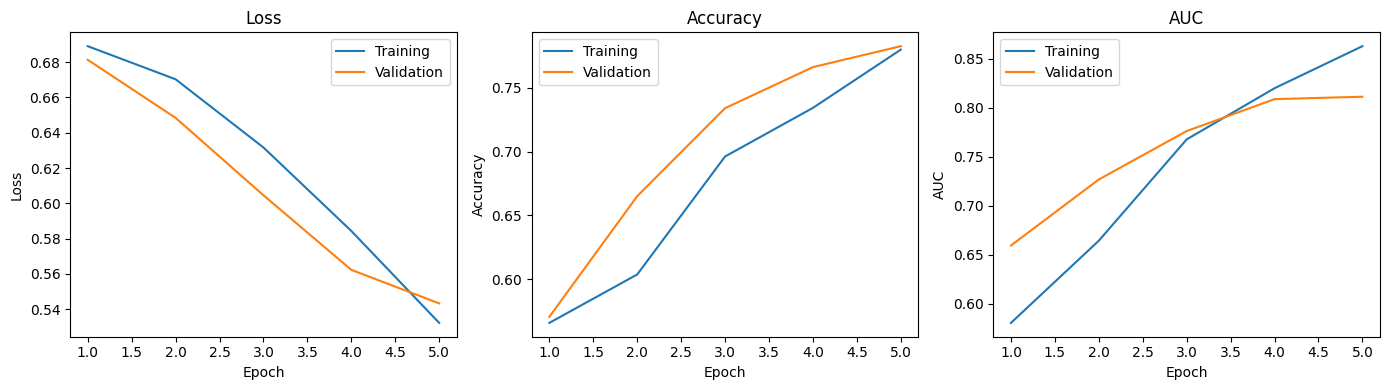

In [27]:

epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])

plt.subplot(1,3,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()

plt.subplot(1,3,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()

plt.subplot(1,3,3)
plt.plot(epoch_range, history['auc'], label='Training')
plt.plot(epoch_range, history['val_auc'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('AUC'); plt.title('AUC')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
model.save("TwitterDisasterModelv2.h5")

c:\Users\OM-FI\Documents\Projects\iml\Deep Learning\Keras NLP\venv\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
len(text_tokenizer.word_index)

15718